In [1]:
# Dependency errors in Sagemaker. Re-install
# !pip install boto3==1.17.106 s3fs pandas==1.3.5
# !pip install numpy --upgrade
# !pip install transformers torch
# !pip install fuzzywuzzy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz, process

import warnings

warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 50)

/Users/han/opt/anaconda3/envs/ads508/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Data Loading

In [3]:
bucket = 's3://ads508-imdb-data'
bucket = '.'

names = pd.read_csv(f'{bucket}/ImdbName.csv', low_memory=False)
akas = pd.read_csv(f'{bucket}/ImdbTitleAkas.csv', low_memory=False)
titles = pd.read_csv(f'{bucket}/ImdbTitleBasics.csv', low_memory=False)
crew = pd.read_csv(f'{bucket}/ImdbTitleCrew.csv', low_memory=False)
episode = pd.read_csv(f'{bucket}/ImdbTitleEpisode.csv', low_memory=False)
principals = pd.read_csv(f'{bucket}/ImdbTitlePrincipals.csv', low_memory=False)
ratings = pd.read_csv(f'{bucket}/ImdbTitleRatings.csv', low_memory=False)
plots = pd.read_csv(f'{bucket}/movies_plots.csv', low_memory=False)
netflix = pd.read_csv(f'{bucket}/NetFlix.csv', low_memory=False)

In [4]:
names.shape, akas.shape, titles.shape, crew.shape, episode.shape, principals.shape, ratings.shape, plots.shape, netflix.shape

((1048575, 6),
 (1048575, 8),
 (1048575, 9),
 (1048575, 3),
 (5652641, 4),
 (1048575, 6),
 (1048575, 3),
 (46014, 21),
 (7787, 12))

#### NOTES

1. The **plots** dataframe contains additional features such as plot and awards


#### TODO (as we progress)

0. Fix encoding issue where some characters in dataframes such as director in **plots** are shown weirdly

1. Because we don't want to recommend movies that Netflix already has, we have to check if what we have appear in their dataset. However, because there is no direct mapping (no IMDB ID in Netflix and vice versa), we will have to use fuzzy matching algorithm to get the confidence level on how two movies from Netflix and IMDB are similar to one another

2. Convert \N values in dataframes (such as **titles**) to either empty string or np.nan (float value) and create histogram

3. Normalize/Standardize any numeric features, if they are heavily skewed

4. Decide what to do on outliers. Remove or keep (sometimes keeping can help)

5. Split **country** column in **plots** separated by comma and convert it into numeric features instead (One-Hot-Encoding)

## Data Exploration

### Definition of any helper functions

In [5]:
# Helper function for plotting values counts

def count_plot(df, col, figsize=(8, 6), n_top=10):
    
    plt.figure(figsize=figsize)
    # Only show n_top number of top features
    df[col].value_counts()[:n_top].plot(kind='barh')

### Main Table

In [6]:
titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [7]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   tconst          1048575 non-null  object
 1   titleType       1048575 non-null  object
 2   primaryTitle    1048575 non-null  object
 3   originalTitle   1048575 non-null  object
 4   isAdult         1048575 non-null  int64 
 5   startYear       1048575 non-null  object
 6   endYear         1048575 non-null  object
 7   runtimeMinutes  1048575 non-null  object
 8   genres          1048575 non-null  object
dtypes: int64(1), object(8)
memory usage: 72.0+ MB


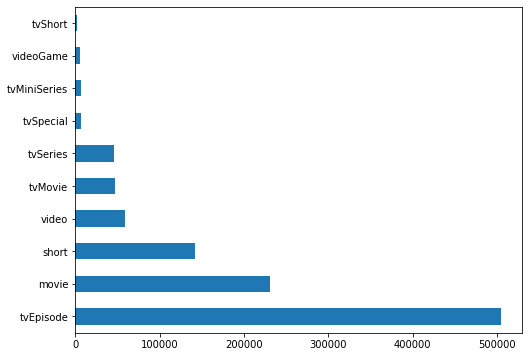

In [8]:
count_plot(titles, 'titleType')

In [9]:
print('Total of {} number of distinct genres combination'.format(titles['genres'].unique().shape[0]))

Total of 1731 number of distinct genres combination


In [10]:
titles['startYear'].value_counts()

2006    64078
2005    61789
2004    53015
2003    43672
2002    36430
        ...  
1890        3
1893        2
1888        2
1889        1
2023        1
Name: startYear, Length: 137, dtype: int64

In [11]:
titles[titles['startYear']=='2023']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
987260,tt10032644,movie,The Urn,The Urn,0,2023,\N,\N,Thriller


In [12]:
titles['endYear'].value_counts()

\N      1030298
2004        774
2005        768
2003        689
2001        663
         ...   
1945          1
2022          1
1938          1
1942          1
1933          1
Name: endYear, Length: 81, dtype: int64

In [13]:
titles[titles['endYear']=='1933']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
362034,tt0377269,tvSeries,The Television Ghost,The Television Ghost,0,1931,1933,15,Drama


In [14]:
titles[titles['runtimeMinutes']=='\\N'] # make sure to escape \ by adding another \

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
18,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,\N,\N,"Comedy,Short"
22,tt0000024,short,Opening of the Kiel Canal,Opening of the Kiel Canal,0,1895,\N,\N,"News,Short"
23,tt0000025,short,The Oxford and Cambridge University Boat Race,The Oxford and Cambridge University Boat Race,0,1895,\N,\N,"News,Short,Sport"
36,tt0000038,short,The Ball Game,The Ball Game,0,1898,\N,\N,"Documentary,Short,Sport"
37,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,\N,\N,Short
...,...,...,...,...,...,...,...,...,...
1048566,tt10140360,movie,Another Night in China,Another Night in China,1,2009,\N,\N,Adult
1048569,tt10140370,tvEpisode,Sarah Clifford,Sarah Clifford,0,2019,\N,\N,Talk-Show
1048571,tt10140378,tvEpisode,Corey Hart,Corey Hart,0,2019,\N,\N,Talk-Show
1048573,tt10140380,short,Fear of Dogs,Fear of Dogs,0,1994,\N,\N,"Drama,Short"


In this table, \N is treated as a null value so replace them for numeric values into nan

In [15]:
titles[titles['runtimeMinutes']=='\\N'].shape, titles[titles['startYear']=='\\N'].shape, titles[titles['endYear']=='\\N'].shape

((513537, 9), (9010, 9), (1030298, 9))

In [16]:
titles[titles['runtimeMinutes']!='\\N']['runtimeMinutes'].astype(int).min(), titles[titles['runtimeMinutes']!='\\N']['runtimeMinutes'].astype(int).max()

(0, 8400)

In [17]:
print('{:.2f}% of whole movies are adult videos'.format(titles['isAdult'].sum() / titles.shape[0] * 100))

4.07% of whole movies are adult videos


---

### Plots

In [18]:
plots.head()

,imdbID,title,year,rating,runtime,genre,released,director,writer,cast,metacritic,imdbRating,imdbVotes,poster,plot,fullplot,language,country,awards,lastupdated,type
0,1,Carmencita,1894,NOT RATED,1 min,"Documentary, Short",NaN,William K.L. Dickson,NaN,Carmencita,NaN,5.9,1032.0,https://m.media-amazon.com/images/M/MV5BMjAzND...,Performing on what looks like a small wooden s...,Performing on what looks like a small wooden s...,NaN,USA,NaN,2015-08-26 00:03:45.040000000,movie
1,5,Blacksmith Scene,1893,UNRATED,1 min,Short,1893-05-09,William K.L. Dickson,NaN,"Charles Kayser, John Ott",NaN,6.2,1189.0,NaN,Three men hammer on an anvil and pass a bottle...,A stationary camera looks at a large anvil wit...,NaN,USA,1 win.,2015-08-26 00:03:50.133000000,movie
2,3,Pauvre Pierrot,1892,NaN,4 min,"Animation, Comedy, Short",1892-10-28,�mile Reynaud,NaN,NaN,NaN,6.7,566.0,NaN,"One night, Arlequin come to see his lover Colo...","One night, Arlequin come to see his lover Colo...",NaN,France,NaN,2015-08-12 00:06:02.720000000,movie
3,8,Edison Kinetoscopic Record of a Sneeze,1894,NaN,1 min,"Documentary, Short",1894-01-09,William K.L. Dickson,NaN,Fred Ott,NaN,5.9,988.0,NaN,A man (Thomas Edison's assistant) takes a pinc...,A man (Edison's assistant) takes a pinch of sn...,NaN,USA,NaN,2015-08-10 00:21:07.127000000,movie
4,10,Employees Leaving the Lumi�re Factory,1895,NaN,1 min,"Documentary, Short",1895-03-22,Louis Lumi�re,NaN,NaN,NaN,6.9,3469.0,NaN,A man opens the big gates to the Lumi�re facto...,A man opens the big gates to the Lumi�re facto...,NaN,France,NaN,2015-08-26 00:03:56.603000000,movie


In [19]:
plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46014 entries, 0 to 46013
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imdbID       46014 non-null  int64  
 1   title        46014 non-null  object 
 2   year         46014 non-null  object 
 3   rating       24629 non-null  object 
 4   runtime      43377 non-null  object 
 5   genre        45615 non-null  object 
 6   released     43002 non-null  object 
 7   director     45409 non-null  object 
 8   writer       42942 non-null  object 
 9   cast         44928 non-null  object 
 10  metacritic   9401 non-null   float64
 11  imdbRating   44300 non-null  float64
 12  imdbVotes    44299 non-null  float64
 13  poster       35798 non-null  object 
 14  plot         42161 non-null  object 
 15  fullplot     41421 non-null  object 
 16  language     44899 non-null  object 
 17  country      45830 non-null  object 
 18  awards       23542 non-null  object 
 19  last

Because we already have most of the columns, extract only the following selected columns to use

In [20]:
cols_to_use = ['imdbID', 'plot', 'fullplot', 'awards', 'country']
plots = plots[cols_to_use]

In [21]:
plots.head()

,imdbID,plot,fullplot,awards,country
0,1,Performing on what looks like a small wooden s...,Performing on what looks like a small wooden s...,NaN,USA
1,5,Three men hammer on an anvil and pass a bottle...,A stationary camera looks at a large anvil wit...,1 win.,USA
2,3,"One night, Arlequin come to see his lover Colo...","One night, Arlequin come to see his lover Colo...",NaN,France
3,8,A man (Thomas Edison's assistant) takes a pinc...,A man (Edison's assistant) takes a pinch of sn...,NaN,USA
4,10,A man opens the big gates to the Lumi�re facto...,A man opens the big gates to the Lumi�re facto...,NaN,France


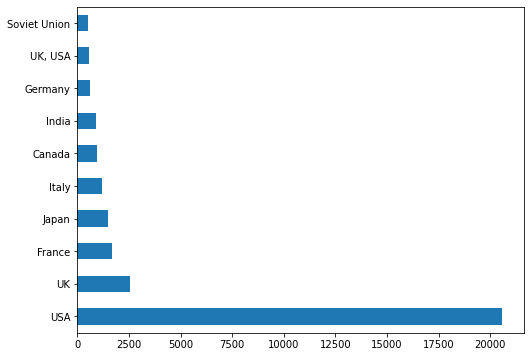

In [22]:
count_plot(plots, 'country')

We can see that there are movies having country of "UK, USA". 

In [23]:
plots[plots['country']=='UK, USA']

,imdbID,plot,fullplot,awards,country
3126,40321,Uncle Rollo finally retires to the house he wa...,Uncle Rollo finally retires to the house he wa...,NaN,"UK, USA"
3129,40325,"Matt Denant, ex-RAF flier, sentenced to three ...",NaN,NaN,"UK, USA"
3286,41329,Arnold Boult is determined to make his son a s...,Arnold Boult is determined to make his son a s...,Nominated for 1 Oscar. Another 1 nomination.,"UK, USA"
3517,42757,"In 1875 London, young Wheeler (who lives by sc...","In 1875 London, young Wheeler (who lives by sc...",NaN,"UK, USA"
3576,43067,The treasure seeking adventures of young Jim H...,Enchanted by the idea of locating treasure bur...,1 nomination.,"UK, USA"
...,...,...,...,...,...
44355,3798628,Follows comedian/author/activist Russell Brand...,Follows comedian/author/activist Russell Brand...,1 win.,"UK, USA"
44505,3890160,After being coerced into working for a crime b...,After being coerced into working for a crime b...,NaN,"UK, USA"
44706,4008652,Unprecedented access to Muhammad Ali's persona...,An intimate and heart-warming look at the man ...,2 nominations.,"UK, USA"
45511,4547056,A scientist and a teacher living in a dystopia...,A scientist and a teacher living in a dystopia...,NaN,"UK, USA"


Because country can have more than one value delimited by a comma, we will split them and apply One-Hot-Encoding as numeric features, columns being unique country value. The value will be 1 if a country appears in that row, 0 if not. It's better than using string value

In [24]:
print('longest number of characters in plot columns is {}'.format(plots['plot'].str.len().max()))
print('longest number of characters in fullplot columns is {}'.format(plots['fullplot'].str.len().max()))

longest number of characters in plot columns is 402.0
longest number of characters in fullplot columns is 9097.0


---

### Ratings

In [25]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1694
1,tt0000002,6.0,210
2,tt0000003,6.5,1441
3,tt0000004,6.1,122
4,tt0000005,6.1,2240


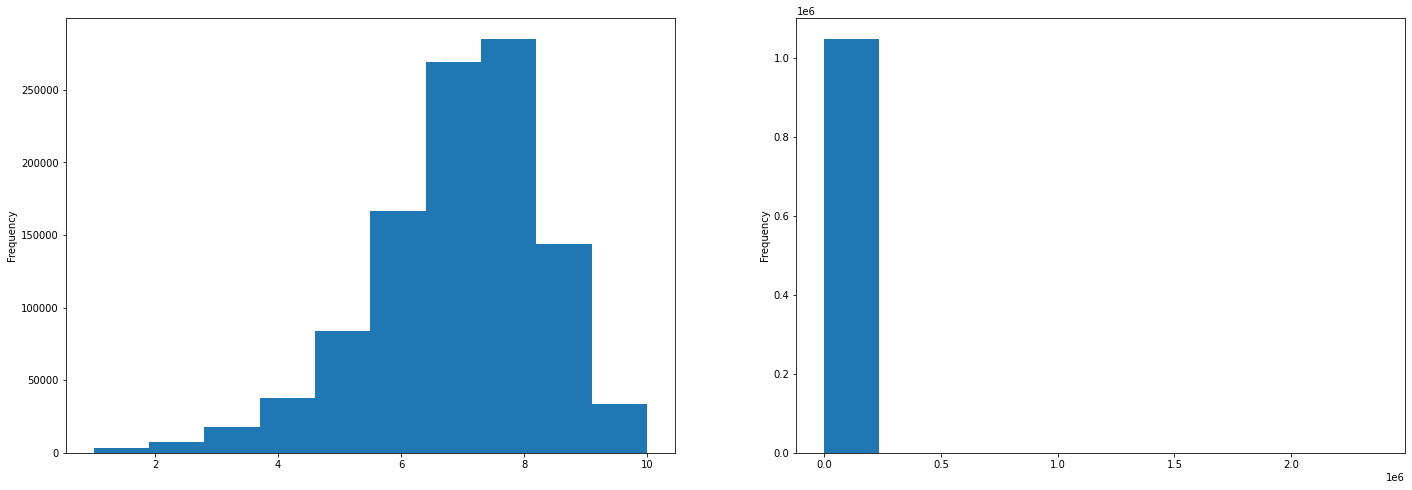

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

ratings['averageRating'].plot(kind='hist', ax=ax[0])
ratings['numVotes'].plot(kind='hist', ax=ax[1])

plt.show();

**numVotes** in ratings are highly skewed, possibly due to outlier

In [27]:
ratings['numVotes'].describe()

count    1.048575e+06
mean     1.006758e+03
std      1.669461e+04
min      5.000000e+00
25%      9.000000e+00
50%      2.000000e+01
75%      8.000000e+01
max      2.369294e+06
Name: numVotes, dtype: float64

Examine movies having less than 100 votes

<AxesSubplot:ylabel='Frequency'>

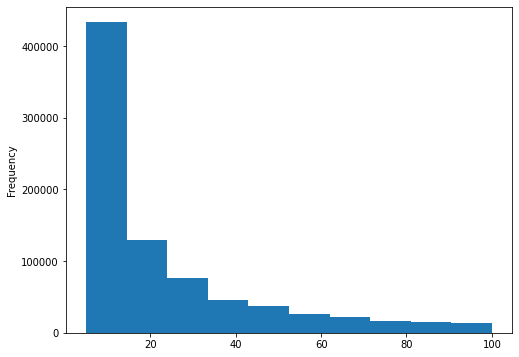

In [28]:
plt.figure(figsize=(8, 6))
ratings[ratings['numVotes']<=100]['numVotes'].plot(kind='hist')

---

### Netflix

In [29]:
netflix.shape

(7787, 12)

In [30]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,14-Aug-20,2020,TV-MA,4,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,15-Dec-17,2008,TV-MA,143,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...
2,s100,Movie,3 Heroines,Iman Brotoseno,"Reza Rahadian, Bunga Citra Lestari, Tara Basro...",Indonesia,5-Jan-19,2016,TV-PG,124,"Dramas, International Movies, Sports Movies",Three Indonesian women break records by becomi...
3,s1000,Movie,Blue Mountain State: The Rise of Thadland,Lev L. Spiro,"Alan Ritchson, Darin Brooks, James Cade, Rob R...",United States,1-Mar-16,2016,R,90,Comedies,New NFL star Thad buys his old teammates' belo...
4,s1001,TV Show,Blue Planet II,NaN,David Attenborough,United Kingdom,3-Dec-18,2017,TV-G,1,"British TV Shows, Docuseries, Science & Nature TV",This sequel to the award-winning nature series...


In [31]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   int64 
 10  genres        7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(2), object(10)
memory usage: 730.2+ KB


<AxesSubplot:>

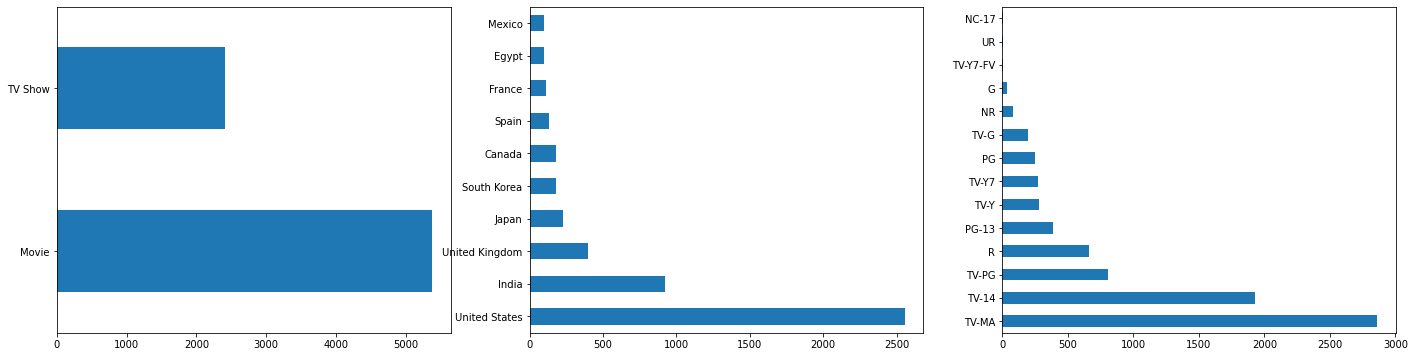

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

netflix['type'].value_counts().plot(kind='barh', ax=ax[0])
netflix['country'].value_counts()[:10].plot(kind='barh', ax=ax[1])
netflix['rating'].value_counts().plot(kind='barh', ax=ax[2])

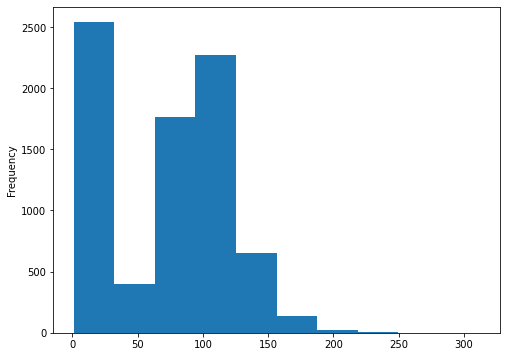

In [33]:
plt.figure(figsize=(8, 6))
netflix['duration'].plot(kind='hist')
plt.show();

Again, just like IMDB titles, their runtime/duration is not normally distributed. Either standardizing or normalizing could help the performance later.

## Data Transformation and Preparation

In [34]:
titles = titles.merge(ratings, on='tconst')
titles['imdb_id'] = titles['tconst'].replace('tt', '', regex=True).astype(int)
titles = titles.merge(plots[['imdbID', 'plot', 'fullplot', 'country', 'awards']], how='inner', left_on='imdb_id', right_on='imdbID')\
                   .drop(columns=['imdb_id'])\
                   .drop_duplicates()

In [35]:
titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,imdbID,plot,fullplot,country,awards
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.6,1694,1,Performing on what looks like a small wooden s...,Performing on what looks like a small wooden s...,USA,NaN
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1441,3,"One night, Arlequin come to see his lover Colo...","One night, Arlequin come to see his lover Colo...",France,NaN
3,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.1,2240,5,Three men hammer on an anvil and pass a bottle...,A stationary camera looks at a large anvil wit...,USA,1 win.
4,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short",5.4,1870,8,A man (Thomas Edison's assistant) takes a pinc...,A man (Edison's assistant) takes a pinch of sn...,USA,NaN
5,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",6.9,6271,10,A man opens the big gates to the Lumi�re facto...,A man opens the big gates to the Lumi�re facto...,France,NaN


### Fuzzy Match

Run fuzzy matching on titles between IMDB and Netflix. This is so that when we recommend list of titles to Netflix, we can filter out any movies that they may already have in their system and only recommend those they don't already have.

In [36]:
netflix.rename(columns={'title':'Netflix Title'}, inplace=True)

In [37]:
def fuzzy_match(x):
    
    global step
    
    results = process.extractOne(x['IMDB Title'].lower(), netflix['Netflix Title'].str.lower().tolist(), scorer=fuzz.ratio)
    
    print('{}/{}'.format(step, titles.shape[0]), flush=True, end='\r')
    
    step += 1
    
    return results[0], results[1]

In [38]:
run_fuzzy_match = False

if run_fuzzy_match:
    match_list = titles[['IMDB Title']].drop_duplicates()

    # step is for printing purpose
    step = 1
    match_list[['Matched Netflix Title', 'Match Score']] = match_list.apply(fuzzy_match, axis=1, result_type="expand")

    # Only keep those titles with 90 or higher match score
    match_list = match_list[match_list['Match Score']>=90]
    
    # save matching result so that we don't have to run again
    match_list.to_csv('match_list.csv', index=False)
    
else:
    match_list = pd.read_csv('match_list.csv')

In [39]:
match_list.head()

,IMDB Title,Matched Netflix Title,Match Score
0,The Great Train Robbery,the great train robbery,100
1,By the Sea,by the sea,100
2,The Captive,the captive,100
3,In the Park,in the dark,91
4,The Tramp,the trap,94


### Transform Genres

When we look at IMDB and Netflix, their genre values are in different format and many are not matching. 

To address this problem, convert Netflix genres so that they can be matched to IMDB (may not be exact but in this way we can use genre column in our model(s))

For those that do not have appropriate genre value to map to, leave them as blank and treat them they are missing genre values in which case, only plot and other features will be used to recommend titles

In [41]:
unique_imdb_genre = ''

for genres in titles['genres']:
    
    unique_imdb_genre = unique_imdb_genre + ',' + genres
    
# Skip the first elem since it is an empty string
unique_imdb_genre = list(set(unique_imdb_genre.split(',')))[1:]
unique_imdb_genre = [x for x in unique_imdb_genre if x!='\\N'] # remove non-genre value


unique_netflix_genre = ''

for genres in netflix['genres']:
    
    genres = genres.replace(' & ', ', ')
    unique_netflix_genre = unique_netflix_genre + ', ' + genres
    
# Skip the first elem since it is an empty string
unique_netflix_genre = list(set(unique_netflix_genre.split(', ')))[1:]

unique_netflix_genre = pd.Series(unique_netflix_genre)
unique_imdb_genre = pd.Series(unique_imdb_genre)

unique_netflix_genre.shape, unique_imdb_genre.shape

((49,), (27,))

In [42]:
unique_imdb_genre.sort_values()

22         Action
24          Adult
11      Adventure
19      Animation
25      Biography
20         Comedy
9           Crime
4     Documentary
14          Drama
6          Family
15        Fantasy
17      Film-Noir
12        History
18         Horror
23          Music
1         Musical
10        Mystery
7            News
13     Reality-TV
5         Romance
26         Sci-Fi
2           Short
8           Sport
16      Talk-Show
0        Thriller
3             War
21        Western
dtype: object

In [43]:
unique_netflix_genre.sort_values()

36                       Action
19                    Adventure
13               Anime Features
40                 Anime Series
35             British TV Shows
16                     Children
1                       Classic
8                Classic Movies
7                      Comedies
12               Crime TV Shows
4                   Cult Movies
44                      Cult TV
3                 Documentaries
26                   Docuseries
31                       Dramas
20                        Faith
32                Family Movies
23                      Fantasy
21                Horror Movies
11           Independent Movies
42         International Movies
34       International TV Shows
43                     Kids' TV
48              Korean TV Shows
14                 LGBTQ Movies
22                       Movies
38                        Music
33                     Musicals
28                    Nature TV
30                   Reality TV
15              Romantic Movies
24      

In [44]:
netflix['genres'] = netflix['genres'].replace(' Movies', '', regex=True)\
                                    .replace(' TV Shows', '', regex=True)\
                                    .replace('TV', '', regex=True)\
                                    .replace("\'", '', regex=True)\
                                    .replace('Anime Series|Anime Features', 'Animation', regex=True)\
                                    .replace('British', 'Western', regex=True)\
                                    .replace('Children|Teen|Kids', 'Family', regex=True)\
                                    .replace('Comedies|Stand-Up Comedy', 'Comedy', regex=True)\
                                    .replace('Cult', 'Thriller', regex=True)\
                                    .replace('Spanish-Language', 'Western', regex=True)\
                                    .replace('Romantic', 'Romance', regex=True)\
                                    .replace('Talk Shows', 'Talk-Show', regex=True)\
                                    .replace('Reality', 'Reality-TV', regex=True)\
                                    .replace('Spirituality', 'Fantasy', regex=True)\
                                    .replace('Science', 'Sci-Fi', regex=True)\
                                    .replace('Sports', 'Sport', regex=True)\
                                    .replace('Thrillers', 'Thriller', regex=True)\
                                    .replace('Mysteries', 'Mystery', regex=True)\
                                    .replace('Documentaries|Nature|Docuseries', 'Documentary', regex=True)\
                                    .replace('Dramas|Classic', 'Drama', regex=True)\
                                    .replace('Musicals', 'Musical', regex=True)\
                                    .replace('Reality-TV-', 'Reality-TV')\
                                    .replace('Korean|LGBTQ|Shows|International|Independent|Faith|Movies', '', regex=True)\
                                    .replace(' & ', ',', regex=True)\
                                    .replace('[ ]+', ',', regex=True)\
                                    .replace('[,]{2,}', ',', regex=True)\
                                    .replace('^[,]|[,]$', '', regex=True)\
                                    .str.strip()

Use KMeans Clustering on IMDB Genres to assign groups of different genre combinations. Using this, also do the same to Netflix and predict their genre group.

In this way, we can compare two movies (one fron IMDB and another from Netflix) if they have similar genre values even if they don't match. For example with title A (Action, Adventure) and title B (Action), they can be considered as being in the same genre group though their values don't match exactly.

Before doing that, apply One-Hot-Encoding on genres to keep count of which genre(s) appear on each title

In [46]:
# For those with missing genres, set it to Unavailable
titles.loc[titles['genres']=='\\N', 'genres'] = 'Unavailable'
netflix.loc[netflix['genres']=='', 'genres'] = 'Unavailable'

In [47]:
titles.reset_index(drop=True, inplace=True)
netflix.reset_index(drop=True, inplace=True)

In [49]:
imdb_genres_count = pd.DataFrame(data=np.zeros((titles.shape[0], unique_imdb_genre.shape[0]+1)), columns=unique_imdb_genre.tolist() + ['Unavailable'], dtype=int)
netflix_genres_count = pd.DataFrame(data=np.zeros((netflix.shape[0], unique_imdb_genre.shape[0]+1)), columns=unique_imdb_genre.tolist() + ['Unavailable'], dtype=int)

for i, x in titles.iterrows():
    genres = x['genres'].split(',')
    for genre in genres:
        imdb_genres_count.loc[i, genre] = 1

for i, x in netflix.iterrows():
    genres = x['genres'].split(',')
    for genre in genres:
        netflix_genres_count.loc[i, genre] = 1

In [51]:
from sklearn.cluster import KMeans

random_state = 123
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, max_iter=3000)
imdb_genre_group = kmeans.fit_predict(imdb_genres_count)

In [52]:
titles['Genre Group'] = imdb_genre_group

In [53]:
netflix_genre_group = kmeans.predict(netflix_genres_count)

In [54]:
netflix['Genre Group'] = netflix_genre_group

### Plots and Description

**plot** is used by IMDB while **description** is used by Netflix. Remove any non-alpha-numeric values (and keep basic punctuations like comma or dot)

In [55]:
pattern = "[^a-zA-Z0-9 .,\']"

titles['plot'] = titles['plot'].str.replace(pattern, '', regex=True)
netflix['description'] = netflix['description'].str.replace(pattern, '', regex=True)

### Other column(s)

In [56]:
# Only keep the startYear which is released Year
titles.drop(columns=['endYear', 'fullplot'], inplace=True)
titles.rename(columns={
    'startYear':'Release Year',
    'primaryTitle':'IMDB Title',
    'tconst':'IMDB ID'
}, inplace=True)

In [57]:
netflix.rename(columns={
    'release_year':'Release Year',
}, inplace=True)

In [58]:
titles['plot'] = titles['plot'].fillna('')
netflix['description'] = netflix['description'].fillna('')

In [59]:
titles = titles[titles['plot']!=''].reset_index(drop=True)
netflix = netflix[netflix['description']!=''].reset_index(drop=True)

In [60]:
titles.head()

,IMDB ID,titleType,IMDB Title,originalTitle,isAdult,Release Year,runtimeMinutes,genres,averageRating,numVotes,imdbID,plot,country,awards,Genre Group
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,"Documentary,Short",5.6,1694,1,Performing on what looks like a small wooden s...,USA,NaN,9
1,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance",6.5,1441,3,"One night, Arlequin come to see his lover Colo...",France,NaN,7
2,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,"Comedy,Short",6.1,2240,5,Three men hammer on an anvil and pass a bottle...,USA,1 win.,1
3,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,1,"Documentary,Short",5.4,1870,8,A man Thomas Edison's assistant takes a pinch ...,USA,NaN,9
4,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,1,"Documentary,Short",6.9,6271,10,A man opens the big gates to the Lumire factor...,France,NaN,9


In [61]:
netflix.head()

,show_id,type,Netflix Title,director,cast,country,date_added,Release Year,rating,duration,genres,description,Genre Group
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,14-Aug-20,2020,TV-MA,4,"Drama,Sci-Fi,Fantasy",In a future where the elite inhabit an island ...,5
1,s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,15-Dec-17,2008,TV-MA,143,"Horror,Thriller",An architect and his wife move into a castle t...,0
2,s100,Movie,3 Heroines,Iman Brotoseno,"Reza Rahadian, Bunga Citra Lestari, Tara Basro...",Indonesia,5-Jan-19,2016,TV-PG,124,"Drama,Sport",Three Indonesian women break records by becomi...,5
3,s1000,Movie,Blue Mountain State: The Rise of Thadland,Lev L. Spiro,"Alan Ritchson, Darin Brooks, James Cade, Rob R...",United States,1-Mar-16,2016,R,90,Comedy,New NFL star Thad buys his old teammates' belo...,1
4,s1001,TV Show,Blue Planet II,NaN,David Attenborough,United Kingdom,3-Dec-18,2017,TV-G,1,"Western,Documentary,Sci-Fi,Documentary",This sequel to the awardwinning nature series ...,9


### Semantics on Synopsis (plot, description)

In [62]:
from utils import get_semantics

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
run_imdb_semantics = False

if run_imdb_semantics:

    for i, x in titles.iterrows():

        synopsis = x['plot']

        if synopsis == '':
            semantic = [0]*768
        else:
            # can take upto 512 characters
            semantic = get_semantics(x['plot'][:512])

        semantic = pd.DataFrame(get_semantics(x['plot'][:512])).transpose()

        if i==0:
            semantic.to_csv('imdb_semantics.csv', index=False)
        else:
            semantic.to_csv('imdb_semantics.csv', index=False, mode='a', header=None)
            
        print('{}/{}'.format(i+1, titles.shape[0]), flush=True, end='\r')
            
else:
    
    imdb_semantics = pd.read_csv('imdb_semantics.csv')

In [64]:
run_netflix_semantics = False

if run_netflix_semantics:

    for i, x in netflix.iterrows():

        synopsis = x['description']

        if synopsis == '':
            semantic = [0]*768
        else:
            # can take upto 512 characters
            semantic = get_semantics(x['description'][:512])

        semantic = pd.DataFrame(get_semantics(x['description'][:512])).transpose()

        if i==0:
            semantic.to_csv('netflix_semantics.csv', index=False)
        else:
            semantic.to_csv('netflix_semantics.csv', index=False, mode='a', header=None)
            
        print('{}/{}'.format(i+1, netflix.shape[0]), flush=True, end='\r')
            
else:
    
    netflix_semantics = pd.read_csv('netflix_semantics.csv')

In [65]:
imdb_semantics.columns = ['Semantic {}'.format(i+1) for i in range(imdb_semantics.shape[1])]
netflix_semantics.columns = ['Semantic {}'.format(i+1) for i in range(netflix_semantics.shape[1])]

In [66]:
titles = pd.concat([titles, imdb_semantics], axis=1)
netflix = pd.concat([netflix, netflix_semantics], axis=1)

In [ ]:
titles.to_csv('processed_imdb.csv', index=False)
netflix.to_csv('processed_netflix.csv', index=False)

In [67]:
titles.head()

,IMDB ID,titleType,IMDB Title,originalTitle,isAdult,Release Year,runtimeMinutes,genres,averageRating,numVotes,imdbID,plot,country,awards,Genre Group,Semantic 1,Semantic 2,Semantic 3,Semantic 4,Semantic 5,Semantic 6,Semantic 7,Semantic 8,Semantic 9,Semantic 10,...,Semantic 744,Semantic 745,Semantic 746,Semantic 747,Semantic 748,Semantic 749,Semantic 750,Semantic 751,Semantic 752,Semantic 753,Semantic 754,Semantic 755,Semantic 756,Semantic 757,Semantic 758,Semantic 759,Semantic 760,Semantic 761,Semantic 762,Semantic 763,Semantic 764,Semantic 765,Semantic 766,Semantic 767,Semantic 768
0,tt0000001,short,Carmencita,Carmencita,0.0,1894,1,"Documentary,Short",5.6,1694.0,1.0,Performing on what looks like a small wooden s...,USA,NaN,9.0,0.141424,-0.160405,0.220831,-0.094910,0.302755,-0.644581,-0.113050,0.375831,-0.469933,0.250917,...,-0.155180,-0.594591,0.198024,0.050538,-0.231643,-0.123184,0.161463,-0.000140,0.073090,0.634666,0.082776,-0.244978,0.607198,-0.113023,-0.336199,-1.042062,0.214003,-0.083587,-0.006674,-0.194486,-0.150251,-0.094577,-0.605529,0.283749,-0.155790
1,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892,4,"Animation,Comedy,Romance",6.5,1441.0,3.0,"One night, Arlequin come to see his lover Colo...",France,NaN,7.0,-0.958055,0.077802,0.530921,-0.371530,0.889130,0.107755,0.139760,0.995286,-0.071266,-0.636390,...,0.092347,-0.060310,-0.176576,-0.281478,0.187778,0.131213,0.617511,0.369944,0.152154,0.197646,0.459663,-0.327837,0.273429,0.377763,-0.156881,-0.066071,-0.284780,0.224536,-0.515511,-0.381292,0.395341,-0.145168,-0.427048,0.292864,0.346208
2,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893,1,"Comedy,Short",6.1,2240.0,5.0,Three men hammer on an anvil and pass a bottle...,USA,1 win.,1.0,0.897383,0.652671,-0.462255,0.316856,0.552451,-0.368404,-0.483213,0.279988,0.532375,-0.342365,...,0.086467,-0.064868,0.043389,-0.149364,-0.639306,0.309520,0.128660,0.097556,-0.384233,0.410434,0.513785,-0.040436,0.594767,-0.010879,-0.162570,-0.749765,-0.348932,-0.229298,0.192425,-0.006430,0.314851,-0.285497,0.380123,-0.002542,-0.434679
3,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0.0,1894,1,"Documentary,Short",5.4,1870.0,8.0,A man Thomas Edison's assistant takes a pinch ...,USA,NaN,9.0,-0.229988,0.298003,0.040624,-0.189754,0.511537,-0.027071,0.148240,0.344687,-0.356588,-0.082086,...,-0.334260,0.096403,0.642389,-0.358850,-0.202062,-0.274481,0.775868,0.502450,-0.191667,0.799281,0.009526,-0.090914,0.430397,0.158188,0.192859,-0.382631,-0.429746,-0.322701,-0.019224,0.153636,0.045824,0.086952,-0.154917,0.119396,0.572872
4,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0.0,1895,1,"Documentary,Short",6.9,6271.0,10.0,A man opens the big gates to the Lumire factor...,France,NaN,9.0,0.324712,0.060831,0.048859,-0.294227,0.470147,-0.188500,-0.533378,0.537322,-0.266497,-0.443631,...,0.232188,-0.158780,-0.438480,0.212007,-0.282541,-0.042789,0.202309,-0.193994,-0.423765,0.442335,0.237479,-0.479914,0.262316,0.192649,-0.324607,-0.185420,-0.400863,-0.277769,0.097244,-0.335937,0.090837,-0.210895,-0.066578,-0.059184,-0.056082


In [68]:
netflix.head()

,show_id,type,Netflix Title,director,cast,country,date_added,Release Year,rating,duration,genres,description,Genre Group,Semantic 1,Semantic 2,Semantic 3,Semantic 4,Semantic 5,Semantic 6,Semantic 7,Semantic 8,Semantic 9,Semantic 10,Semantic 11,Semantic 12,...,Semantic 744,Semantic 745,Semantic 746,Semantic 747,Semantic 748,Semantic 749,Semantic 750,Semantic 751,Semantic 752,Semantic 753,Semantic 754,Semantic 755,Semantic 756,Semantic 757,Semantic 758,Semantic 759,Semantic 760,Semantic 761,Semantic 762,Semantic 763,Semantic 764,Semantic 765,Semantic 766,Semantic 767,Semantic 768
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,14-Aug-20,2020,TV-MA,4,"Drama,Sci-Fi,Fantasy",In a future where the elite inhabit an island ...,5,-0.074138,-0.302046,0.278525,0.096129,0.114581,-0.247718,0.120474,0.320554,-0.138567,-0.446237,-0.034870,-0.177575,...,-0.059079,-0.103498,0.028687,-0.301453,0.024764,-0.440775,0.223165,-0.049643,0.069372,0.226386,0.314339,-0.435582,0.607599,-0.116721,-0.049537,-0.538659,-0.052227,0.035186,0.298150,0.059797,0.250116,-0.421163,-0.263913,0.135168,-0.042835
1,s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,15-Dec-17,2008,TV-MA,143,"Horror,Thriller",An architect and his wife move into a castle t...,0,-0.067776,-0.244456,0.650776,-0.199541,0.761016,-0.226246,0.040268,0.159779,0.404399,-0.143716,0.105969,-0.125654,...,0.248903,-0.031151,0.017622,-0.209629,-0.015144,-0.019575,0.658037,-0.108004,-0.579253,0.365246,0.567539,-0.572805,0.030720,-0.091910,-0.560325,-0.452894,-0.675485,-0.166111,-0.106259,-0.369100,0.534542,-0.391329,-0.505261,0.065416,0.252679
2,s100,Movie,3 Heroines,Iman Brotoseno,"Reza Rahadian, Bunga Citra Lestari, Tara Basro...",Indonesia,5-Jan-19,2016,TV-PG,124,"Drama,Sport",Three Indonesian women break records by becomi...,5,-0.613586,0.142603,-0.270360,-0.371017,0.011493,-0.298804,0.126409,0.153722,-0.953736,0.468890,0.508114,-0.625574,...,-0.331881,0.210750,0.338233,-0.799976,-0.387136,-0.093619,0.521291,-0.063949,-0.253886,0.715695,0.120137,-0.071739,0.649491,-0.324814,-0.525757,0.315896,0.162501,-0.071881,0.016402,0.187876,0.083418,-0.242689,-0.252881,0.035388,-0.425325
3,s1000,Movie,Blue Mountain State: The Rise of Thadland,Lev L. Spiro,"Alan Ritchson, Darin Brooks, James Cade, Rob R...",United States,1-Mar-16,2016,R,90,Comedy,New NFL star Thad buys his old teammates' belo...,1,-0.245754,0.143419,0.147061,-0.150548,0.500170,-0.334806,0.217135,1.031148,0.297689,0.041634,0.170355,-0.426644,...,0.065998,-0.331790,0.305016,-0.219187,0.233044,0.310744,0.422537,-0.085393,0.010411,0.389176,0.613290,-0.303374,0.176517,-0.017561,-0.308537,-0.554449,0.001212,-0.010456,0.130359,0.025739,-0.212267,-0.560338,-0.059075,0.367698,-0.012123
4,s1001,TV Show,Blue Planet II,NaN,David Attenborough,United Kingdom,3-Dec-18,2017,TV-G,1,"Western,Documentary,Sci-Fi,Documentary",This sequel to the awardwinning nature series ...,9,0.246156,0.035644,0.453414,0.091013,0.457504,-0.577794,-0.197095,0.717904,-0.233222,-0.242040,0.394441,-0.672937,...,0.033947,-0.052567,0.189405,0.256048,-0.265686,-0.596994,0.479132,0.406965,-0.275125,0.211416,0.176698,-0.342747,0.139836,-0.096281,-0.646915,-0.309526,0.231067,-0.285924,0.005509,-0.116425,0.131404,0.599980,0.252970,0.534538,-0.150926


In [69]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Columns: 781 entries, show_id to Semantic 768
dtypes: float64(768), int32(1), int64(2), object(10)
memory usage: 46.4+ MB


In [70]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30258 entries, 0 to 30257
Columns: 783 entries, IMDB ID to Semantic 768
dtypes: float64(773), object(10)
memory usage: 181.0+ MB
